<a href="https://colab.research.google.com/github/possakorn/UoA_DL_2023_3_PK/blob/main/Assignment02_v3.0.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assessment 2: CNNs for image classification

## Setup: import lib

In [1]:
## section: Data manioulation
import pandas as pd
import numpy as np
import random
## visualization
import plotly
import matplotlib.pyplot as plt
import seaborn as sns

## section: neural network
import torch
## pytorch: dataset
import torchvision
from torchvision import models
## pytorch: network and function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR, OneCycleLR

from torchsummary import summary

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# setting device on GPU if available, else CPU
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device == torch.device('cuda'):
  worker = 4
else:
  worker = 0
print('Using device:', device, 'Using number of workers: ', worker)
print()


#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

# Set the seed for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

Using device: cuda Using number of workers:  4

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/usr/local/lib/python3.10/dist-packages/torch/cuda/memory.py:444: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


## Step01: Data exploration

In [3]:
## Download from cifar10
dataset = 'cifar100' # change this one
set_seed(1311)
training_data = datasets.CIFAR100(
    root="data",
    train=True,
    download = True,
    transform= transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)

testing_data = datasets.CIFAR100(
    root="data",
    train=False,
    download = True,
    transform= transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)

100%|██████████| 169001437/169001437 [00:10<00:00, 16235491.35it/s]


Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified


### Exploratory Image analysis

Check Shape of images:  torch.Size([3, 32, 32]) 11
Preview Images with Label : apple
Show of images unique 100 labels:  ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank',

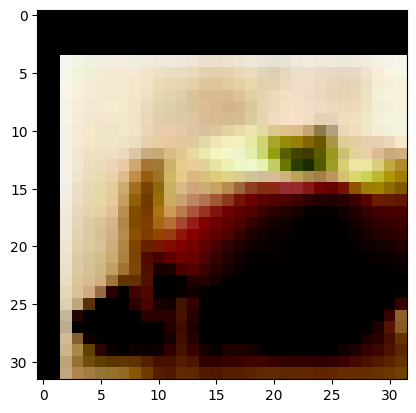

In [4]:
## check shape and labels
img, label = training_data[3]
print("Check Shape of images: ",img.shape,label)

def display_img(img,label):
  print(f"Preview Images with Label : {training_data.classes[label]}")
  plt.imshow(img.permute(1,2,0)) # for visualization following the plt need to change the shapes

#display the first image in the dataset
display_img(*training_data[2])

#Show all labels
classes = training_data.classes
num_class = len(classes)
print(f"Show of images unique {num_class} labels: ",classes)


### Tranforms to Dataloader

In [5]:
batch_size = 16

## setting the split configuration
set_seed(1311)
train_size = int(0.8 * len(training_data))
val_size = len(training_data) - train_size
training_data, val_data = random_split(training_data, [train_size, val_size])

## apply the dataloader
set_seed(1311)

trainloader = torch.utils.data.DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=worker,
    pin_memory = True
    )
valloader = torch.utils.data.DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=worker,
    pin_memory = True
    )
testloader = torch.utils.data.DataLoader(
    testing_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=worker,
    pin_memory = True
    )

# check the splitting
num_items_train = len(trainloader.dataset)
num_items_val = len(valloader.dataset)
num_items_test = len(testloader.dataset)

num_batches_train = len(trainloader)
num_batches_val = len(valloader)
num_batches_test = len(testloader)

print("Training set: {} items, {} batches".format(num_items_train, num_batches_train))
print("Validation set: {} items, {} batches".format(num_items_val, num_batches_val))
print("Test set: {} items, {} batches".format(num_items_test, num_batches_test))

Training set: 40000 items, 2500 batches
Validation set: 10000 items, 625 batches
Test set: 10000 items, 625 batches


### Review the Batch fig and size

torch.Size([16, 3, 32, 32])


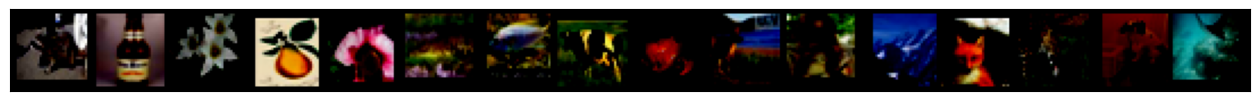

In [6]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

## show the batch fig
show_batch(trainloader)

## print the size
for batch in trainloader:
    print(batch[0].shape)  # Assuming batch[0] contains the data and batch[1] contains the labels
    break

## Base Model Functions For Image Classification

In [7]:
import time
from tqdm import tqdm

def train_epoch(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in tqdm(trainloader, desc='Training'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_train += torch.sum(preds == labels.data)
        total_train += labels.size(0)

    epoch_loss = running_loss / total_train
    epoch_acc = correct_train.double() / total_train
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)

    loss = running_loss / total
    accuracy = correct.double() / total
    return loss, accuracy


def train_network(model, optimizer, criterion, scheduler, trainloader, valloader, testloader, num_epochs, device, num_class, model_name, dataset):
    set_seed(1311)
    ## Set up the path for saving the model
    PATH = f'./{dataset}_{model_name}.pth'
    print('Model will be saved to:', PATH)
    print('Using device:', device, 'with seed: 1311')
    print()

    ## Initialize variables
    best_val_acc = 0  # to track the best validation accuracy
    # create set to collect the output
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': [],
    }

    class_correct = list(0. for i in range(num_class))
    class_total = list(0. for i in range(num_class))

    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, valloader, criterion, device)


        # Step the scheduler with the validation loss
        scheduler.step()
        # scheduler.step(val_acc) # for ReduceLROnPlateau

        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(100 * train_acc)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(100 * val_acc)

        # Save the model if it has improved on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), PATH)
            print(f'Model improved and saved to {PATH}')

        # print epoch results
        epoch_end_time = time.time()
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Acc: {100 * train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {100 * val_acc:.2f}%, '
              f'Time: {epoch_end_time - epoch_start_time:.2f}s')

    print('Training complete. Evaluating on test set with the best model...')

    # Load the best model for final evaluation on test set
    best_model = model
    best_model.load_state_dict(torch.load(PATH))
    test_loss, test_acc = evaluate(best_model, testloader, criterion, device)
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {100 * test_acc:.2f}%')

    # Add test results to history
    history['test_loss'] = test_loss
    history['test_accuracy'] = 100 * test_acc

    return history

## Initialize network

### network: SimpleCNN

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=num_class):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### network: Alexnet

In [9]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=num_class):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x



### network: ResNet18

In [10]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes,
                               kernel_size=3, stride=stride, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes,
                               kernel_size=3,stride=1, padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride,
                          bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=num_class):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])

def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

## Train the network

In [11]:
def plot_loss(train_loss, val_loss):
    if isinstance(train_loss[0], torch.Tensor):
        train_loss = [x.cpu().numpy() for x in train_loss]
    if isinstance(val_loss[0], torch.Tensor):
        val_loss = [x.cpu().numpy() for x in val_loss]

    plt.plot(train_loss, '-bx')
    plt.plot(val_loss, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

def plot_acc(train_acc, val_acc):
    if isinstance(train_acc[0], torch.Tensor):
        train_acc = [x.cpu().numpy() for x in train_acc]
    if isinstance(val_acc[0], torch.Tensor):
        val_acc = [x.cpu().numpy() for x in val_acc]

    plt.plot(train_acc, '-bx')
    plt.plot(val_acc, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')
    plt.show()

In [12]:
# set the whole network training
num_epochs = 20
criterion = nn.CrossEntropyLoss()


### Train the network - simpleCNN

Model will be saved to: ./cifar100_simplecnn.pth
Using device: cuda with seed: 1311



Evaluating: 100%|██████████| 625/625 [00:01<00:00, 325.96it/s]


Model improved and saved to ./cifar100_simplecnn.pth
Epoch 1/20, Train Loss: 4.5614, Train Acc: 1.87%, Val Loss: 4.3606, Val Acc: 3.87%, Time: 19.92s


Evaluating: 100%|██████████| 625/625 [00:01<00:00, 313.19it/s]


Model improved and saved to ./cifar100_simplecnn.pth
Epoch 2/20, Train Loss: 4.0456, Train Acc: 7.83%, Val Loss: 3.8666, Val Acc: 10.05%, Time: 11.82s


Evaluating: 100%|██████████| 625/625 [00:01<00:00, 319.13it/s]


Model improved and saved to ./cifar100_simplecnn.pth
Epoch 3/20, Train Loss: 3.7245, Train Acc: 12.78%, Val Loss: 3.6395, Val Acc: 14.22%, Time: 11.42s


Evaluating: 100%|██████████| 625/625 [00:02<00:00, 306.49it/s]


Model improved and saved to ./cifar100_simplecnn.pth
Epoch 4/20, Train Loss: 3.5080, Train Acc: 16.34%, Val Loss: 3.4275, Val Acc: 18.16%, Time: 11.49s


Evaluating: 100%|██████████| 625/625 [00:01<00:00, 319.64it/s]


Model improved and saved to ./cifar100_simplecnn.pth
Epoch 5/20, Train Loss: 3.3250, Train Acc: 19.62%, Val Loss: 3.2810, Val Acc: 20.59%, Time: 11.30s


Evaluating: 100%|██████████| 625/625 [00:01<00:00, 333.68it/s]


Model improved and saved to ./cifar100_simplecnn.pth
Epoch 6/20, Train Loss: 3.1685, Train Acc: 22.39%, Val Loss: 3.1278, Val Acc: 23.80%, Time: 11.42s


Evaluating: 100%|██████████| 625/625 [00:01<00:00, 327.54it/s]


Model improved and saved to ./cifar100_simplecnn.pth
Epoch 7/20, Train Loss: 3.0383, Train Acc: 24.99%, Val Loss: 3.0395, Val Acc: 25.16%, Time: 11.49s


Evaluating: 100%|██████████| 625/625 [00:01<00:00, 318.34it/s]


Model improved and saved to ./cifar100_simplecnn.pth
Epoch 8/20, Train Loss: 2.9203, Train Acc: 27.27%, Val Loss: 2.9327, Val Acc: 27.46%, Time: 11.29s


Evaluating: 100%|██████████| 625/625 [00:01<00:00, 328.17it/s]


Model improved and saved to ./cifar100_simplecnn.pth
Epoch 9/20, Train Loss: 2.8120, Train Acc: 29.30%, Val Loss: 2.8523, Val Acc: 28.69%, Time: 11.41s


Evaluating: 100%|██████████| 625/625 [00:02<00:00, 302.12it/s]


Model improved and saved to ./cifar100_simplecnn.pth
Epoch 10/20, Train Loss: 2.7106, Train Acc: 31.39%, Val Loss: 2.8381, Val Acc: 29.23%, Time: 11.80s


Evaluating: 100%|██████████| 625/625 [00:01<00:00, 318.25it/s]


Model improved and saved to ./cifar100_simplecnn.pth
Epoch 11/20, Train Loss: 2.6153, Train Acc: 33.34%, Val Loss: 2.7986, Val Acc: 30.12%, Time: 12.38s


Evaluating: 100%|██████████| 625/625 [00:01<00:00, 328.13it/s]


Model improved and saved to ./cifar100_simplecnn.pth
Epoch 12/20, Train Loss: 2.5266, Train Acc: 35.30%, Val Loss: 2.6789, Val Acc: 32.42%, Time: 11.77s


Evaluating: 100%|██████████| 625/625 [00:02<00:00, 304.21it/s]


Model improved and saved to ./cifar100_simplecnn.pth
Epoch 13/20, Train Loss: 2.4462, Train Acc: 37.02%, Val Loss: 2.6048, Val Acc: 33.89%, Time: 11.80s


Evaluating: 100%|██████████| 625/625 [00:01<00:00, 322.01it/s]


Model improved and saved to ./cifar100_simplecnn.pth
Epoch 14/20, Train Loss: 2.3678, Train Acc: 38.50%, Val Loss: 2.5869, Val Acc: 34.58%, Time: 11.45s


Evaluating: 100%|██████████| 625/625 [00:01<00:00, 325.29it/s]


Model improved and saved to ./cifar100_simplecnn.pth
Epoch 15/20, Train Loss: 2.2947, Train Acc: 39.80%, Val Loss: 2.4894, Val Acc: 36.46%, Time: 11.51s


Evaluating: 100%|██████████| 625/625 [00:01<00:00, 321.65it/s]


Model improved and saved to ./cifar100_simplecnn.pth
Epoch 16/20, Train Loss: 2.2212, Train Acc: 41.41%, Val Loss: 2.4834, Val Acc: 36.68%, Time: 11.69s


Evaluating: 100%|██████████| 625/625 [00:02<00:00, 303.73it/s]


Model improved and saved to ./cifar100_simplecnn.pth
Epoch 17/20, Train Loss: 2.1579, Train Acc: 43.13%, Val Loss: 2.4230, Val Acc: 38.10%, Time: 11.76s


Evaluating: 100%|██████████| 625/625 [00:01<00:00, 321.81it/s]


Model improved and saved to ./cifar100_simplecnn.pth
Epoch 18/20, Train Loss: 2.0892, Train Acc: 44.77%, Val Loss: 2.3945, Val Acc: 39.33%, Time: 11.62s


Evaluating: 100%|██████████| 625/625 [00:01<00:00, 323.37it/s]


Model improved and saved to ./cifar100_simplecnn.pth
Epoch 19/20, Train Loss: 2.0279, Train Acc: 46.16%, Val Loss: 2.3551, Val Acc: 39.76%, Time: 11.52s


Evaluating: 100%|██████████| 625/625 [00:01<00:00, 323.53it/s]


Epoch 20/20, Train Loss: 1.9751, Train Acc: 46.94%, Val Loss: 2.3524, Val Acc: 39.40%, Time: 11.50s
Training complete. Evaluating on test set with the best model...


Evaluating: 100%|██████████| 625/625 [00:01<00:00, 398.63it/s]


Test Loss: 2.2322, Test Acc: 42.70%


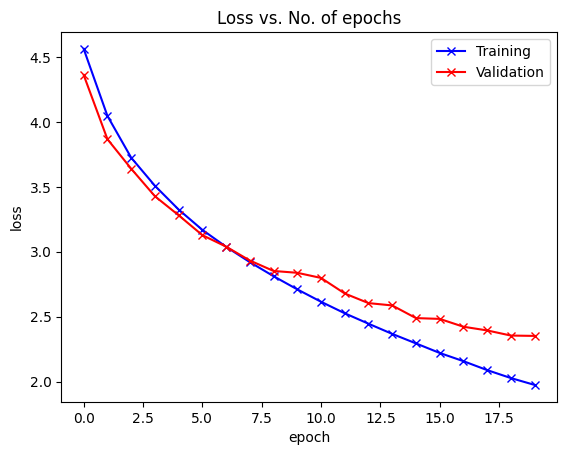

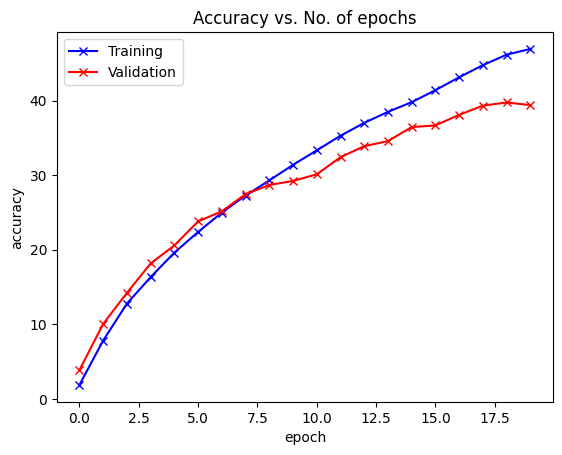

Test Loss: 2.2322, Test Accuracy: 42.70%


In [13]:
# individual configuration
simplecnn = SimpleCNN().to(device)
model_name = "simplecnn"
model = simplecnn
# Assuming `model` is your neural network model and `lr` is your learning rate
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)

# training model
simplecnn_results = train_network(model,
                                  optimizer,
                                  criterion,
                                  scheduler,
                                  trainloader,
                                  valloader,
                                  testloader,
                                  num_epochs,
                                  device,
                                  num_class,
                                  model_name,
                                  dataset
                                  )

# Plot the results
plot_loss(simplecnn_results['train_loss'], simplecnn_results['val_loss'])
plot_acc(simplecnn_results['train_accuracy'], simplecnn_results['val_accuracy'])
# Print Test Loss and Test Accuracy
print(f'Test Loss: {simplecnn_results["test_loss"]:.4f}, Test Accuracy: {simplecnn_results["test_accuracy"]:.2f}%')

### Train the network - Alexnet

Model will be saved to: ./cifar100_alexnet.pth
Using device: cuda with seed: 1311



Evaluating: 100%|██████████| 625/625 [00:02<00:00, 268.07it/s]


Model improved and saved to ./cifar100_alexnet.pth
Epoch 1/20, Train Loss: 4.6055, Train Acc: 0.97%, Val Loss: 4.6056, Val Acc: 0.83%, Time: 41.15s


Evaluating: 100%|██████████| 625/625 [00:02<00:00, 279.74it/s]


Model improved and saved to ./cifar100_alexnet.pth
Epoch 2/20, Train Loss: 4.6052, Train Acc: 1.03%, Val Loss: 4.6057, Val Acc: 0.87%, Time: 41.29s


Evaluating: 100%|██████████| 625/625 [00:02<00:00, 273.62it/s]


Epoch 3/20, Train Loss: 4.6046, Train Acc: 1.30%, Val Loss: 4.6045, Val Acc: 0.83%, Time: 40.97s


Evaluating: 100%|██████████| 625/625 [00:02<00:00, 273.52it/s]


Model improved and saved to ./cifar100_alexnet.pth
Epoch 4/20, Train Loss: 4.5639, Train Acc: 1.33%, Val Loss: 4.4239, Val Acc: 2.69%, Time: 41.59s


Evaluating: 100%|██████████| 625/625 [00:02<00:00, 270.84it/s]


Model improved and saved to ./cifar100_alexnet.pth
Epoch 5/20, Train Loss: 4.2058, Train Acc: 4.90%, Val Loss: 4.0628, Val Acc: 6.30%, Time: 41.75s


Evaluating: 100%|██████████| 625/625 [00:02<00:00, 278.17it/s]


Model improved and saved to ./cifar100_alexnet.pth
Epoch 6/20, Train Loss: 4.0046, Train Acc: 7.16%, Val Loss: 3.9199, Val Acc: 8.54%, Time: 41.89s


Evaluating: 100%|██████████| 625/625 [00:02<00:00, 283.45it/s]


Model improved and saved to ./cifar100_alexnet.pth
Epoch 7/20, Train Loss: 3.8585, Train Acc: 9.42%, Val Loss: 3.7869, Val Acc: 10.70%, Time: 41.48s


Evaluating: 100%|██████████| 625/625 [00:02<00:00, 269.26it/s]


Model improved and saved to ./cifar100_alexnet.pth
Epoch 8/20, Train Loss: 3.7268, Train Acc: 11.40%, Val Loss: 3.6537, Val Acc: 12.76%, Time: 42.04s


Evaluating: 100%|██████████| 625/625 [00:02<00:00, 281.31it/s]


Model improved and saved to ./cifar100_alexnet.pth
Epoch 9/20, Train Loss: 3.5946, Train Acc: 13.96%, Val Loss: 3.4865, Val Acc: 15.90%, Time: 41.79s


Evaluating: 100%|██████████| 625/625 [00:02<00:00, 277.17it/s]


Model improved and saved to ./cifar100_alexnet.pth
Epoch 10/20, Train Loss: 3.4462, Train Acc: 16.63%, Val Loss: 3.3282, Val Acc: 18.44%, Time: 41.80s


Evaluating: 100%|██████████| 625/625 [00:02<00:00, 276.77it/s]


Model improved and saved to ./cifar100_alexnet.pth
Epoch 11/20, Train Loss: 3.3119, Train Acc: 18.95%, Val Loss: 3.2377, Val Acc: 19.64%, Time: 42.02s


Evaluating: 100%|██████████| 625/625 [00:02<00:00, 277.55it/s]


Model improved and saved to ./cifar100_alexnet.pth
Epoch 12/20, Train Loss: 3.1819, Train Acc: 21.28%, Val Loss: 3.1011, Val Acc: 22.63%, Time: 41.90s


Evaluating: 100%|██████████| 625/625 [00:02<00:00, 265.14it/s]


Model improved and saved to ./cifar100_alexnet.pth
Epoch 13/20, Train Loss: 3.0631, Train Acc: 23.69%, Val Loss: 2.9697, Val Acc: 25.31%, Time: 42.11s


Evaluating: 100%|██████████| 625/625 [00:02<00:00, 280.03it/s]


Model improved and saved to ./cifar100_alexnet.pth
Epoch 14/20, Train Loss: 2.9458, Train Acc: 25.78%, Val Loss: 2.8824, Val Acc: 27.59%, Time: 41.90s


Evaluating: 100%|██████████| 625/625 [00:02<00:00, 272.97it/s]


Model improved and saved to ./cifar100_alexnet.pth
Epoch 15/20, Train Loss: 2.8306, Train Acc: 28.00%, Val Loss: 2.7423, Val Acc: 29.79%, Time: 41.82s


Evaluating: 100%|██████████| 625/625 [00:02<00:00, 272.76it/s]


Model improved and saved to ./cifar100_alexnet.pth
Epoch 16/20, Train Loss: 2.7302, Train Acc: 30.06%, Val Loss: 2.6873, Val Acc: 30.86%, Time: 42.09s


Evaluating: 100%|██████████| 625/625 [00:02<00:00, 282.38it/s]


Model improved and saved to ./cifar100_alexnet.pth
Epoch 17/20, Train Loss: 2.6290, Train Acc: 31.62%, Val Loss: 2.5678, Val Acc: 33.84%, Time: 41.81s


Evaluating: 100%|██████████| 625/625 [00:02<00:00, 269.38it/s]


Model improved and saved to ./cifar100_alexnet.pth
Epoch 18/20, Train Loss: 2.5518, Train Acc: 33.46%, Val Loss: 2.5326, Val Acc: 34.51%, Time: 41.94s


Evaluating: 100%|██████████| 625/625 [00:02<00:00, 276.74it/s]


Model improved and saved to ./cifar100_alexnet.pth
Epoch 19/20, Train Loss: 2.4646, Train Acc: 35.27%, Val Loss: 2.4763, Val Acc: 36.02%, Time: 42.00s


Evaluating: 100%|██████████| 625/625 [00:02<00:00, 270.17it/s]


Model improved and saved to ./cifar100_alexnet.pth
Epoch 20/20, Train Loss: 2.3863, Train Acc: 37.19%, Val Loss: 2.3671, Val Acc: 37.37%, Time: 41.92s
Training complete. Evaluating on test set with the best model...


Evaluating: 100%|██████████| 625/625 [00:02<00:00, 282.32it/s]


Test Loss: 2.2821, Test Acc: 39.98%


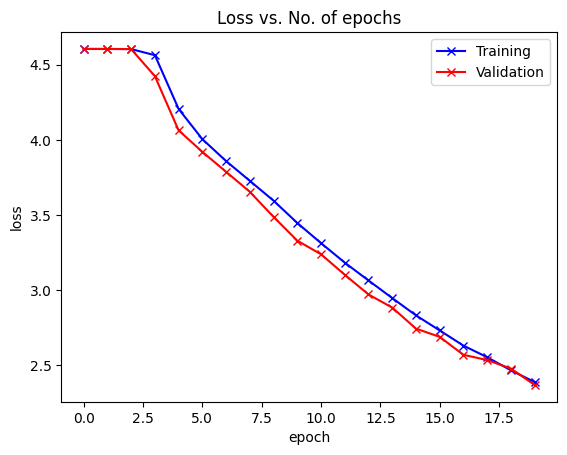

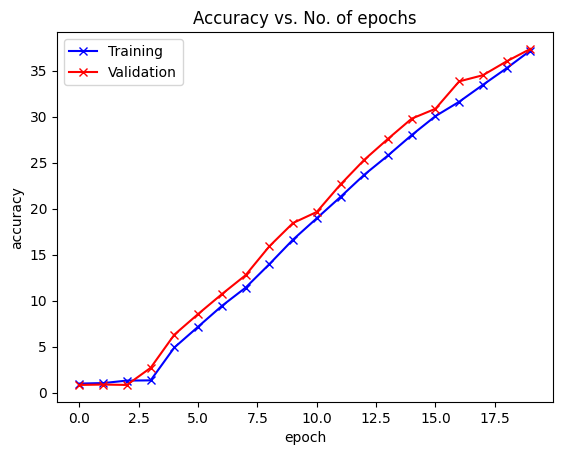

Test Loss: 2.2821, Test Accuracy: 39.98%


In [14]:
# individual configuration
alexnet = AlexNet().to(device)
model_name = "alexnet"
model = alexnet

# Assuming `model` is your neural network model and `lr` is your learning rate
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)


# training model
alexnet_results = train_network(model,
                                  optimizer,
                                  criterion,
                                  scheduler,
                                  trainloader,
                                  valloader,
                                  testloader,
                                  num_epochs,
                                  device,
                                  num_class,
                                  model_name,
                                  dataset
                                  )

# Plot the results
plot_loss(alexnet_results['train_loss'], alexnet_results['val_loss'])
plot_acc(alexnet_results['train_accuracy'], alexnet_results['val_accuracy'])
# Print Test Loss and Test Accuracy
print(f'Test Loss: {alexnet_results["test_loss"]:.4f}, Test Accuracy: {alexnet_results["test_accuracy"]:.2f}%')

### Train the network - Resnet18

Model will be saved to: ./cifar100_resnet18.pth
Using device: cuda with seed: 1311



Evaluating: 100%|██████████| 625/625 [00:03<00:00, 172.26it/s]


Model improved and saved to ./cifar100_resnet18.pth
Epoch 1/20, Train Loss: 3.7830, Train Acc: 11.88%, Val Loss: 3.3669, Val Acc: 18.83%, Time: 59.72s


Evaluating: 100%|██████████| 625/625 [00:03<00:00, 171.27it/s]


Model improved and saved to ./cifar100_resnet18.pth
Epoch 2/20, Train Loss: 3.0624, Train Acc: 24.07%, Val Loss: 2.8367, Val Acc: 28.09%, Time: 59.26s


Evaluating: 100%|██████████| 625/625 [00:03<00:00, 172.07it/s]


Model improved and saved to ./cifar100_resnet18.pth
Epoch 3/20, Train Loss: 2.5896, Train Acc: 33.16%, Val Loss: 2.3592, Val Acc: 37.83%, Time: 59.34s


Evaluating: 100%|██████████| 625/625 [00:03<00:00, 173.39it/s]


Model improved and saved to ./cifar100_resnet18.pth
Epoch 4/20, Train Loss: 2.2699, Train Acc: 40.01%, Val Loss: 2.0332, Val Acc: 44.87%, Time: 59.14s


Evaluating: 100%|██████████| 625/625 [00:03<00:00, 173.86it/s]


Model improved and saved to ./cifar100_resnet18.pth
Epoch 5/20, Train Loss: 2.0234, Train Acc: 45.59%, Val Loss: 1.9448, Val Acc: 47.40%, Time: 59.19s


Evaluating: 100%|██████████| 625/625 [00:03<00:00, 174.56it/s]


Model improved and saved to ./cifar100_resnet18.pth
Epoch 6/20, Train Loss: 1.8527, Train Acc: 49.16%, Val Loss: 1.8024, Val Acc: 50.67%, Time: 59.22s


Evaluating: 100%|██████████| 625/625 [00:03<00:00, 167.90it/s]


Model improved and saved to ./cifar100_resnet18.pth
Epoch 7/20, Train Loss: 1.7007, Train Acc: 52.82%, Val Loss: 1.7451, Val Acc: 52.01%, Time: 58.97s


Evaluating: 100%|██████████| 625/625 [00:03<00:00, 170.42it/s]


Model improved and saved to ./cifar100_resnet18.pth
Epoch 8/20, Train Loss: 1.5871, Train Acc: 55.71%, Val Loss: 1.5955, Val Acc: 55.40%, Time: 59.53s


Evaluating: 100%|██████████| 625/625 [00:03<00:00, 171.90it/s]


Model improved and saved to ./cifar100_resnet18.pth
Epoch 9/20, Train Loss: 1.4804, Train Acc: 58.15%, Val Loss: 1.5618, Val Acc: 56.28%, Time: 59.12s


Evaluating: 100%|██████████| 625/625 [00:03<00:00, 173.22it/s]


Model improved and saved to ./cifar100_resnet18.pth
Epoch 10/20, Train Loss: 1.3832, Train Acc: 60.56%, Val Loss: 1.5020, Val Acc: 58.06%, Time: 59.32s


Evaluating: 100%|██████████| 625/625 [00:03<00:00, 169.77it/s]


Model improved and saved to ./cifar100_resnet18.pth
Epoch 11/20, Train Loss: 1.2971, Train Acc: 62.69%, Val Loss: 1.4857, Val Acc: 58.21%, Time: 59.52s


Evaluating: 100%|██████████| 625/625 [00:03<00:00, 169.62it/s]


Model improved and saved to ./cifar100_resnet18.pth
Epoch 12/20, Train Loss: 1.2119, Train Acc: 64.80%, Val Loss: 1.4639, Val Acc: 59.23%, Time: 59.49s


Evaluating: 100%|██████████| 625/625 [00:03<00:00, 171.81it/s]


Model improved and saved to ./cifar100_resnet18.pth
Epoch 13/20, Train Loss: 1.1521, Train Acc: 66.40%, Val Loss: 1.3973, Val Acc: 61.06%, Time: 59.15s


Evaluating: 100%|██████████| 625/625 [00:03<00:00, 173.53it/s]


Model improved and saved to ./cifar100_resnet18.pth
Epoch 14/20, Train Loss: 1.0756, Train Acc: 68.34%, Val Loss: 1.3701, Val Acc: 61.91%, Time: 59.34s


Evaluating: 100%|██████████| 625/625 [00:03<00:00, 167.87it/s]


Epoch 15/20, Train Loss: 1.0205, Train Acc: 69.77%, Val Loss: 1.3641, Val Acc: 61.69%, Time: 58.93s


Evaluating: 100%|██████████| 625/625 [00:03<00:00, 168.25it/s]


Model improved and saved to ./cifar100_resnet18.pth
Epoch 16/20, Train Loss: 0.9574, Train Acc: 71.45%, Val Loss: 1.3492, Val Acc: 63.56%, Time: 59.24s


Evaluating: 100%|██████████| 625/625 [00:03<00:00, 167.65it/s]


Model improved and saved to ./cifar100_resnet18.pth
Epoch 17/20, Train Loss: 0.8962, Train Acc: 73.19%, Val Loss: 1.2925, Val Acc: 64.12%, Time: 59.68s


Evaluating: 100%|██████████| 625/625 [00:03<00:00, 165.79it/s]


Model improved and saved to ./cifar100_resnet18.pth
Epoch 18/20, Train Loss: 0.8390, Train Acc: 74.90%, Val Loss: 1.3102, Val Acc: 64.27%, Time: 59.41s


Evaluating: 100%|██████████| 625/625 [00:03<00:00, 172.52it/s]


Epoch 19/20, Train Loss: 0.7812, Train Acc: 76.49%, Val Loss: 1.3052, Val Acc: 64.26%, Time: 59.69s


Evaluating: 100%|██████████| 625/625 [00:03<00:00, 171.61it/s]


Model improved and saved to ./cifar100_resnet18.pth
Epoch 20/20, Train Loss: 0.7293, Train Acc: 77.76%, Val Loss: 1.2865, Val Acc: 65.06%, Time: 59.26s
Training complete. Evaluating on test set with the best model...


Evaluating: 100%|██████████| 625/625 [00:03<00:00, 166.28it/s]


Test Loss: 1.3273, Test Acc: 65.72%


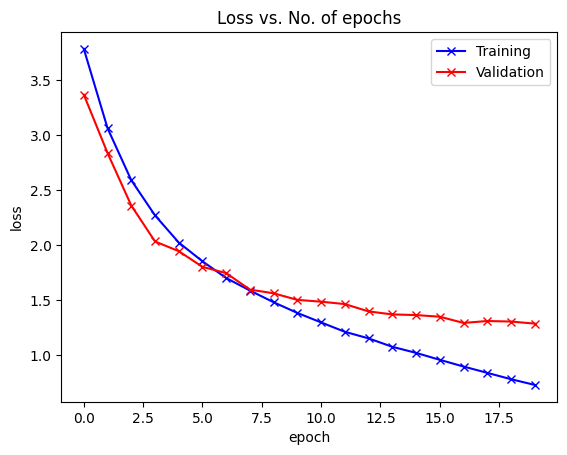

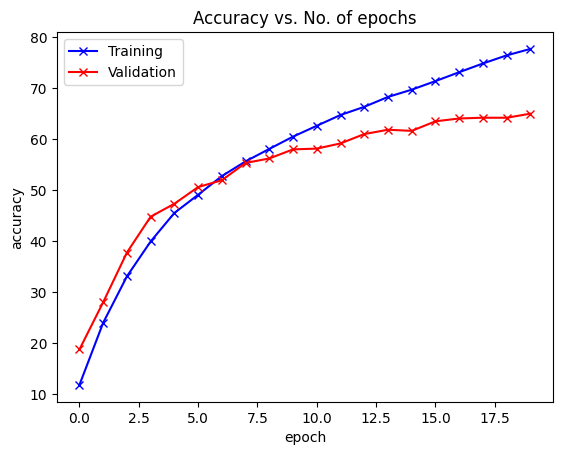

In [15]:
# individual configuration
resnet18 = ResNet18().to(device)
model_name = "resnet18"
model = resnet18

# Assuming `model` is your neural network model and `lr` is your learning rate
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)

# training model
resnet18_results = train_network(model,
                                  optimizer,
                                  criterion,
                                  scheduler,
                                  trainloader,
                                  valloader,
                                  testloader,
                                  num_epochs,
                                  device,
                                  num_class,
                                  model_name,
                                  dataset
                                  )

# Plot the results
plot_loss(resnet18_results['train_loss'], resnet18_results['val_loss'])
plot_acc(resnet18_results['train_accuracy'], resnet18_results['val_accuracy'])

### Train the network - Resnet34

Model will be saved to: ./cifar100_resnet34.pth
Using device: cuda with seed: 1311



Evaluating: 100%|██████████| 625/625 [00:06<00:00, 100.81it/s]


Model improved and saved to ./cifar100_resnet34.pth
Epoch 1/20, Train Loss: 3.8667, Train Acc: 10.62%, Val Loss: 3.3345, Val Acc: 19.05%, Time: 102.05s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 100.71it/s]


Model improved and saved to ./cifar100_resnet34.pth
Epoch 2/20, Train Loss: 3.2110, Train Acc: 21.25%, Val Loss: 2.9602, Val Acc: 26.08%, Time: 102.35s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 101.64it/s]


Model improved and saved to ./cifar100_resnet34.pth
Epoch 3/20, Train Loss: 2.7466, Train Acc: 29.77%, Val Loss: 2.6474, Val Acc: 33.07%, Time: 102.21s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 100.04it/s]


Model improved and saved to ./cifar100_resnet34.pth
Epoch 4/20, Train Loss: 2.4129, Train Acc: 36.93%, Val Loss: 2.2175, Val Acc: 41.02%, Time: 102.00s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 101.42it/s]


Model improved and saved to ./cifar100_resnet34.pth
Epoch 5/20, Train Loss: 2.1459, Train Acc: 42.58%, Val Loss: 2.1039, Val Acc: 43.66%, Time: 101.98s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 100.21it/s]


Model improved and saved to ./cifar100_resnet34.pth
Epoch 6/20, Train Loss: 1.9544, Train Acc: 46.88%, Val Loss: 1.8932, Val Acc: 48.47%, Time: 101.95s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 100.85it/s]


Model improved and saved to ./cifar100_resnet34.pth
Epoch 7/20, Train Loss: 1.7970, Train Acc: 50.41%, Val Loss: 1.8279, Val Acc: 49.85%, Time: 102.03s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 99.42it/s] 


Model improved and saved to ./cifar100_resnet34.pth
Epoch 8/20, Train Loss: 1.6690, Train Acc: 53.53%, Val Loss: 1.6493, Val Acc: 54.27%, Time: 102.42s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 101.41it/s]


Model improved and saved to ./cifar100_resnet34.pth
Epoch 9/20, Train Loss: 1.5579, Train Acc: 56.32%, Val Loss: 1.6535, Val Acc: 54.80%, Time: 101.67s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 101.51it/s]


Model improved and saved to ./cifar100_resnet34.pth
Epoch 10/20, Train Loss: 1.4558, Train Acc: 58.81%, Val Loss: 1.5676, Val Acc: 56.39%, Time: 101.78s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 101.94it/s]


Model improved and saved to ./cifar100_resnet34.pth
Epoch 11/20, Train Loss: 1.3760, Train Acc: 60.63%, Val Loss: 1.5069, Val Acc: 58.36%, Time: 101.36s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 100.28it/s]


Epoch 12/20, Train Loss: 1.2822, Train Acc: 63.28%, Val Loss: 1.5310, Val Acc: 57.92%, Time: 101.41s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 100.80it/s]


Model improved and saved to ./cifar100_resnet34.pth
Epoch 13/20, Train Loss: 1.2260, Train Acc: 64.47%, Val Loss: 1.4439, Val Acc: 60.21%, Time: 102.03s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 100.10it/s]


Epoch 14/20, Train Loss: 1.1467, Train Acc: 66.41%, Val Loss: 1.4636, Val Acc: 59.44%, Time: 101.62s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 99.17it/s] 


Model improved and saved to ./cifar100_resnet34.pth
Epoch 15/20, Train Loss: 1.0867, Train Acc: 68.02%, Val Loss: 1.3734, Val Acc: 62.00%, Time: 102.06s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 100.86it/s]


Model improved and saved to ./cifar100_resnet34.pth
Epoch 16/20, Train Loss: 1.0251, Train Acc: 69.76%, Val Loss: 1.3504, Val Acc: 62.80%, Time: 102.09s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 101.01it/s]


Model improved and saved to ./cifar100_resnet34.pth
Epoch 17/20, Train Loss: 0.9613, Train Acc: 71.61%, Val Loss: 1.3493, Val Acc: 63.10%, Time: 102.01s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 99.68it/s] 


Model improved and saved to ./cifar100_resnet34.pth
Epoch 18/20, Train Loss: 0.9037, Train Acc: 73.29%, Val Loss: 1.3591, Val Acc: 63.64%, Time: 102.00s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 101.70it/s]


Model improved and saved to ./cifar100_resnet34.pth
Epoch 19/20, Train Loss: 0.8521, Train Acc: 74.58%, Val Loss: 1.2978, Val Acc: 64.12%, Time: 101.82s


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 101.69it/s]


Epoch 20/20, Train Loss: 0.7986, Train Acc: 76.17%, Val Loss: 1.3242, Val Acc: 63.96%, Time: 102.32s
Training complete. Evaluating on test set with the best model...


Evaluating: 100%|██████████| 625/625 [00:06<00:00, 100.49it/s]


Test Loss: 1.2842, Test Acc: 65.24%


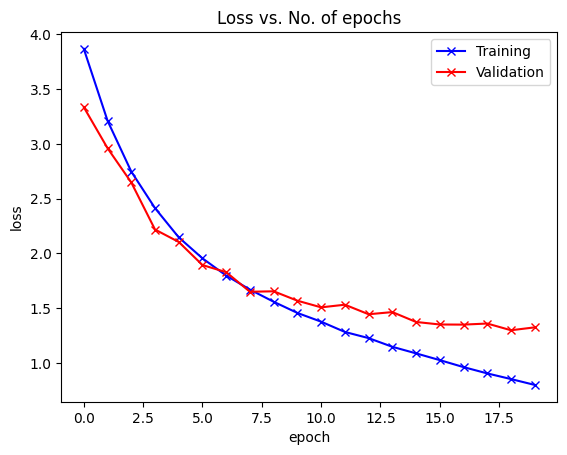

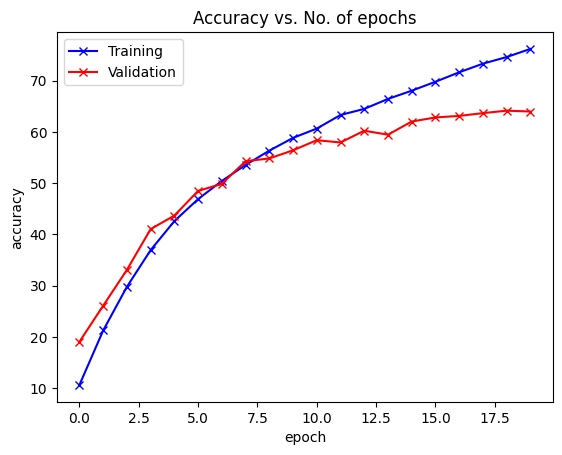

In [16]:
# individual configuration
resnet34 = ResNet34().to(device)
model_name = "resnet34"
model = resnet34

# Assuming `model` is your neural network model and `lr` is your learning rate
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)

# training model
resnet34_results = train_network(model,
                                  optimizer,
                                  criterion,
                                  scheduler,
                                  trainloader,
                                  valloader,
                                  testloader,
                                  num_epochs,
                                  device,
                                  num_class,
                                  model_name,
                                  dataset
                                  )


# Plot the results
plot_loss(resnet34_results['train_loss'], resnet34_results['val_loss'])
plot_acc(resnet34_results['train_accuracy'], resnet34_results['val_accuracy'])

### Train the network - Resnet50

Model will be saved to: ./cifar100_resnet50.pth
Using device: cuda with seed: 1311



Evaluating: 100%|██████████| 625/625 [00:10<00:00, 58.30it/s]


Model improved and saved to ./cifar100_resnet50.pth
Epoch 1/20, Train Loss: 4.1216, Train Acc: 7.46%, Val Loss: 3.7072, Val Acc: 13.09%, Time: 183.70s


Evaluating: 100%|██████████| 625/625 [00:10<00:00, 58.33it/s]


Model improved and saved to ./cifar100_resnet50.pth
Epoch 2/20, Train Loss: 3.5400, Train Acc: 15.25%, Val Loss: 3.4889, Val Acc: 19.81%, Time: 183.64s


Evaluating: 100%|██████████| 625/625 [00:10<00:00, 58.66it/s]


Model improved and saved to ./cifar100_resnet50.pth
Epoch 3/20, Train Loss: 3.1385, Train Acc: 21.88%, Val Loss: 3.0692, Val Acc: 26.40%, Time: 183.39s


Evaluating: 100%|██████████| 625/625 [00:10<00:00, 58.28it/s]


Model improved and saved to ./cifar100_resnet50.pth
Epoch 4/20, Train Loss: 2.7708, Train Acc: 29.01%, Val Loss: 2.5751, Val Acc: 33.61%, Time: 183.37s


Evaluating: 100%|██████████| 625/625 [00:10<00:00, 58.42it/s]


Model improved and saved to ./cifar100_resnet50.pth
Epoch 5/20, Train Loss: 2.4692, Train Acc: 35.52%, Val Loss: 2.8088, Val Acc: 37.17%, Time: 183.53s


Evaluating: 100%|██████████| 625/625 [00:10<00:00, 58.54it/s]


Model improved and saved to ./cifar100_resnet50.pth
Epoch 6/20, Train Loss: 2.2397, Train Acc: 40.24%, Val Loss: 2.2292, Val Acc: 41.60%, Time: 183.48s


Evaluating: 100%|██████████| 625/625 [00:10<00:00, 58.16it/s]


Model improved and saved to ./cifar100_resnet50.pth
Epoch 7/20, Train Loss: 2.0466, Train Acc: 44.71%, Val Loss: 2.1143, Val Acc: 44.99%, Time: 183.66s


Evaluating: 100%|██████████| 625/625 [00:10<00:00, 58.46it/s]


Model improved and saved to ./cifar100_resnet50.pth
Epoch 8/20, Train Loss: 1.8946, Train Acc: 48.26%, Val Loss: 1.8814, Val Acc: 49.23%, Time: 183.63s


Evaluating: 100%|██████████| 625/625 [00:10<00:00, 58.39it/s]


Model improved and saved to ./cifar100_resnet50.pth
Epoch 9/20, Train Loss: 1.7632, Train Acc: 51.11%, Val Loss: 1.7384, Val Acc: 52.05%, Time: 183.56s


Evaluating: 100%|██████████| 625/625 [00:10<00:00, 58.39it/s]


Model improved and saved to ./cifar100_resnet50.pth
Epoch 10/20, Train Loss: 1.6358, Train Acc: 54.39%, Val Loss: 1.6619, Val Acc: 54.16%, Time: 183.93s


Evaluating: 100%|██████████| 625/625 [00:10<00:00, 58.37it/s]


Model improved and saved to ./cifar100_resnet50.pth
Epoch 11/20, Train Loss: 1.5461, Train Acc: 56.08%, Val Loss: 1.5889, Val Acc: 55.51%, Time: 183.55s


Evaluating: 100%|██████████| 625/625 [00:10<00:00, 58.36it/s]


Model improved and saved to ./cifar100_resnet50.pth
Epoch 12/20, Train Loss: 1.4351, Train Acc: 59.04%, Val Loss: 1.5859, Val Acc: 56.39%, Time: 183.69s


Evaluating: 100%|██████████| 625/625 [00:10<00:00, 58.50it/s]


Model improved and saved to ./cifar100_resnet50.pth
Epoch 13/20, Train Loss: 1.3591, Train Acc: 61.00%, Val Loss: 1.4785, Val Acc: 58.52%, Time: 183.55s


Evaluating: 100%|██████████| 625/625 [00:10<00:00, 58.43it/s]


Model improved and saved to ./cifar100_resnet50.pth
Epoch 14/20, Train Loss: 1.2848, Train Acc: 62.93%, Val Loss: 1.4773, Val Acc: 59.11%, Time: 183.66s


Evaluating: 100%|██████████| 625/625 [00:10<00:00, 58.41it/s]


Model improved and saved to ./cifar100_resnet50.pth
Epoch 15/20, Train Loss: 1.2120, Train Acc: 64.58%, Val Loss: 1.3856, Val Acc: 61.34%, Time: 183.58s


Evaluating: 100%|██████████| 625/625 [00:10<00:00, 58.41it/s]


Epoch 16/20, Train Loss: 1.1488, Train Acc: 66.64%, Val Loss: 1.4018, Val Acc: 61.10%, Time: 183.27s


Evaluating: 100%|██████████| 625/625 [00:10<00:00, 58.36it/s]


Model improved and saved to ./cifar100_resnet50.pth
Epoch 17/20, Train Loss: 1.0746, Train Acc: 68.55%, Val Loss: 1.3339, Val Acc: 62.99%, Time: 183.56s


Evaluating: 100%|██████████| 625/625 [00:10<00:00, 58.10it/s]


Epoch 18/20, Train Loss: 1.0111, Train Acc: 69.96%, Val Loss: 1.3621, Val Acc: 62.55%, Time: 183.48s


Evaluating: 100%|██████████| 625/625 [00:10<00:00, 58.37it/s]


Model improved and saved to ./cifar100_resnet50.pth
Epoch 19/20, Train Loss: 0.9516, Train Acc: 71.58%, Val Loss: 1.3197, Val Acc: 63.55%, Time: 183.70s


Evaluating: 100%|██████████| 625/625 [00:10<00:00, 58.33it/s]


Model improved and saved to ./cifar100_resnet50.pth
Epoch 20/20, Train Loss: 0.8917, Train Acc: 73.35%, Val Loss: 1.2854, Val Acc: 64.46%, Time: 183.60s
Training complete. Evaluating on test set with the best model...


Evaluating: 100%|██████████| 625/625 [00:10<00:00, 58.51it/s]


Test Loss: 1.3118, Test Acc: 65.58%


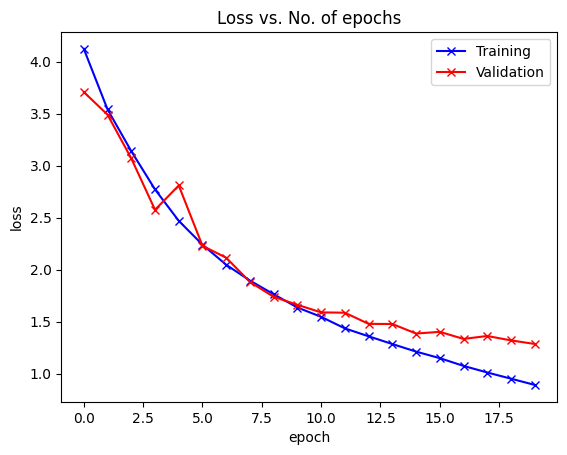

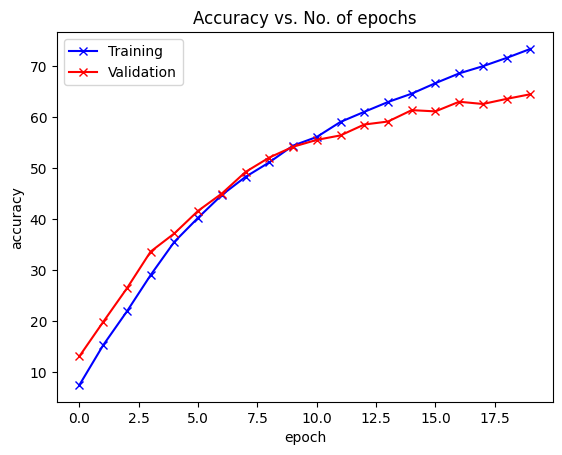

In [17]:
# individual configuration
resnet50 = ResNet50().to(device)
model_name = "resnet50"
model = resnet50

# Assuming `model` is your neural network model and `lr` is your learning rate
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)

# training model
resnet50_results = train_network(model,
                                  optimizer,
                                  criterion,
                                  scheduler,
                                  trainloader,
                                  valloader,
                                  testloader,
                                  num_epochs,
                                  device,
                                  num_class,
                                  model_name,
                                  dataset
                                  )

# Plot the results
plot_loss(resnet50_results['train_loss'], resnet50_results['val_loss'])
plot_acc(resnet50_results['train_accuracy'], resnet50_results['val_accuracy'])

## Load the Model